I'll use this to do data prep for the whole Canada model, which I'll use primarily for the confidence intervals it'll provide

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from postalcodes_ca import fsa_codes
import datetime
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
import folium
from folium import GeoJson

Reading file of transactions

In [2]:
df = pd.read_csv(r'C:\Users\mwendwa.kiko\Documents\Personal_Kiko\Old_UofT\Research\TraderCanada\AutoTrader_Data\univ-of-toronto\UnivOfToronto_Delistings_20240417132304.csv')

In [3]:
df.head()

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,delisted_ads
0,202012,T6B,Dealer,NaN,BMW,M,GasolineFuel,14,Sedan,New,1
1,202012,M5A,Dealer,NaN,Lexus,ES,Gas,0,Sedan,New,1
2,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,3
3,202011,V3H,Dealer,NaN,Lexus,IS,NaN,4,NaN,New,1
4,202012,M5A,Dealer,NaN,Lexus,IS,NaN,4,Sedan,New,1


In [4]:
df['year_grouped'] = df['year'].apply(lambda x: '1900-2005' if x <= 2005 else 
                                                    ('2006-2010' if x <= 2010 else ('2011-2015' if x <= 2016 else 
                                                                                    ('2017-2020' if x <= 2020 else 
                                                                                     '2021-2024'))))

In [5]:
df['yr_month_dtype'] = pd.to_datetime(df['yr_month'], format='%Y%m')
df['yr_month_dtype']

0          2020-12-01
1          2020-12-01
2          2020-10-01
3          2020-11-01
4          2020-12-01
              ...    
15175927   2024-02-01
15175928   2023-08-01
15175929   2023-11-01
15175930   2024-03-01
15175931   2024-02-01
Name: yr_month_dtype, Length: 15175932, dtype: datetime64[ns]

In [6]:
list_fsas_all = list(fsa_codes.keys())
len(list_fsas_all)

1651

In [7]:
df['Seller_FSA'] = df['Seller_FSA'].replace({'BH2': 'B2H', 'NOR': 'N0R'}).str.upper()

# Drop all rows with wrong fsas
df = df[df['Seller_FSA'].isin(list_fsas_all)]
df

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,delisted_ads,year_grouped,yr_month_dtype
0,202012,T6B,Dealer,NaN,BMW,M,GasolineFuel,14,Sedan,New,1,2021-2024,2020-12-01
1,202012,M5A,Dealer,NaN,Lexus,ES,Gas,0,Sedan,New,1,2021-2024,2020-12-01
2,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,3,2021-2024,2020-10-01
3,202011,V3H,Dealer,NaN,Lexus,IS,NaN,4,NaN,New,1,2021-2024,2020-11-01
4,202012,M5A,Dealer,NaN,Lexus,IS,NaN,4,Sedan,New,1,2021-2024,2020-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15175927,202402,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,8,2021-2024,2024-02-01
15175928,202308,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,2,2021-2024,2023-08-01
15175929,202311,B3K,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,1,2021-2024,2023-11-01
15175930,202403,P7B,Dealer,2025.0,Ram,1500,Gas,0,Truck,New,3,2021-2024,2024-03-01


In [8]:
df['Standard_fuel_types'] = df['Fuel_Type'].replace({'Gasoline': 'ICEV', 'Gas': 'ICEV', 'GasolineFuel': 'ICEV', 'Diesel': 'Diesel', 
                                                     'PremiumUnleaded': 'ICEV', 'RegularUnleaded': 'ICEV', 'GasolineHybrid': 'HEV',
                                                     'Flexible': 'Flexible', 'Electric': 'BEV', 'Gas/ElectricHybrid': 'HEV', 'DieselFuel': 'Diesel',
                                                     'Gasoline - Hybrid': 'HEV', 'PremiumUnleaded91Octane': 'ICEV', 'Compressed Natural Gas': 'AFV', 
                                                     'Gasoline-Hybrid': 'HEV', 'E85-Gasoline(FlexFuel)': 'Flexible', 'Gasoline Fuel': 'ICEV', 'CompressedNaturalGas': 'AFV',
                                                      'Propane': 'AFV', 'E85- Gasoline(Flex Fuel)': 'Flexible', 'Premium Unleaded 91 Octane': 'ICEV', 'Premium Unleaded': 'ICEV',
                                                      'GaseousFuelCompatible': 'AFV', 'Regular Unleaded': 'ICEV', 'Gaseous Fuel Compatible': 'AFV', 'FlexFuelCapability': 'Flexible',
                                                      'Diesel Fuel': 'Diesel', 'Flex Fuel Capability': 'Flexible', 'NaturalGas': 'AFV', 'Gas/Electric Hybrid': 'HEV', 'Gasoline Hybrid': 'HEV',
                                                      'E85 - Gasoline (Flex Fuel)': 'Flexible', 'Natural Gas': 'AFV'
                                                     })

In [9]:
# Group by CMAUID, aggregating by count of EVs and total number of listings
df_grouped = df.groupby(['year_grouped', 'yr_month_dtype'])['Standard_fuel_types'].value_counts().unstack().fillna(0)
df_grouped['Total'] = df_grouped.sum(axis=1)
df_grouped['EV_percentage'] = df_grouped['BEV'] / df_grouped['Total']
df_grouped

Standard_fuel_types           AFV     BEV  Diesel  Flexible     HEV     ICEV  \
year_grouped yr_month_dtype                                                    
1900-2005    2016-01-01      10.0     1.0   495.0      53.0    44.0  13305.0   
             2016-02-01       7.0     1.0   414.0      43.0    37.0  11546.0   
             2016-03-01      11.0     1.0   479.0      52.0    44.0  13444.0   
             2016-04-01      10.0     0.0   501.0      52.0    56.0  14212.0   
             2016-05-01      11.0     2.0   522.0      61.0    48.0  15740.0   
...                           ...     ...     ...       ...     ...      ...   
2021-2024    2023-11-01       1.0  3160.0  3600.0     568.0  4125.0  42854.0   
             2023-12-01       1.0  3069.0  3668.0     523.0  4018.0  41170.0   
             2024-01-01       3.0  3390.0  3716.0     542.0  4350.0  46259.0   
             2024-02-01       2.0  3630.0  3990.0     623.0  4430.0  47557.0   
             2024-03-01       0.0  4171.0  4430.0     611.0  4962.0  54019.0   

Standard_fuel_types          Other  Other/Don’t Know  Other/Don’tKnow  \
year_grouped yr_month_dtype                                             
1900-2005    2016-01-01       15.0               0.0              8.0   
             2016-02-01       13.0               0.0              6.0   
             2016-03-01       26.0               0.0              4.0   
             2016-04-01       14.0               0.0              4.0   
             2016-05-01       14.0               0.0              9.0   
...                            ...               ...              ...   
2021-2024    2023-11-01       60.0               0.0              2.0   
             2023-12-01       41.0               0.0              1.0   
             2024-01-01       74.0               0.0              1.0   
             2024-02-01       29.0               0.0              3.0   
             2024-03-01       55.0               0.0              3.0   

Standard_fuel_types            Total  EV_percentage  
year_grouped yr_month_dtype                          
1900-2005    2016-01-01      13931.0       0.000072  
             2016-02-01      12067.0       0.000083  
             2016-03-01      14061.0       0.000071  
             2016-04-01      14849.0       0.000000  
             2016-05-01      16407.0       0.000122  
...                              ...            ...  
2021-2024    2023-11-01      54370.0       0.058120  
             2023-12-01      52491.0       0.058467  
             2024-01-01      58335.0       0.058113  
             2024-02-01      60264.0       0.060235  
             2024-03-01      68251.0       0.061113  

[474 rows x 11 columns]

In [10]:
df_grouped = df_grouped.loc[:, ['BEV', 'Total']].reset_index()
df_grouped


Standard_fuel_types,year_grouped,yr_month_dtype,BEV,Total
0,1900-2005,2016-01-01,1.0,13931.0
1,1900-2005,2016-02-01,1.0,12067.0
2,1900-2005,2016-03-01,1.0,14061.0
3,1900-2005,2016-04-01,0.0,14849.0
4,1900-2005,2016-05-01,2.0,16407.0
...,...,...,...,...
469,2021-2024,2023-11-01,3160.0,54370.0
470,2021-2024,2023-12-01,3069.0,52491.0
471,2021-2024,2024-01-01,3390.0,58335.0
472,2021-2024,2024-02-01,3630.0,60264.0


First, get the market size that you'll use for estimation

In [11]:
market_size_90_perc = df_grouped['Total'].quantile(0.9)
market_size_90_perc

67905.7

In [14]:
log_gomp_input = df_grouped.set_index(['year_grouped', 'yr_month_dtype'])['BEV']
log_gomp_input = log_gomp_input.unstack(level=0).fillna(0).reset_index()
log_gomp_input

year_grouped,yr_month_dtype,1900-2005,2006-2010,2011-2015,2017-2020,2021-2024
0,2016-01-01,1.0,2.0,126.0,0.0,0.0
1,2016-02-01,1.0,4.0,133.0,0.0,0.0
2,2016-03-01,1.0,6.0,138.0,8.0,0.0
3,2016-04-01,0.0,1.0,164.0,7.0,0.0
4,2016-05-01,2.0,5.0,173.0,7.0,0.0
...,...,...,...,...,...,...
94,2023-11-01,0.0,0.0,209.0,1075.0,3160.0
95,2023-12-01,0.0,0.0,240.0,848.0,3069.0
96,2024-01-01,1.0,0.0,183.0,1002.0,3390.0
97,2024-02-01,0.0,0.0,195.0,1055.0,3630.0


In [27]:
log_gomp_input['2021-2024'].sum() + log_gomp_input['2017-2020'].sum() + log_gomp_input['2011-2015'].sum() + log_gomp_input['2006-2010'].sum() + log_gomp_input['1900-2005'].sum()

155167.0

So this does include all EVs. 

In [15]:
log_gomp_input['months_passed_01_2017'] = (log_gomp_input['yr_month_dtype'] - datetime.datetime(2017, 1, 1)) / np.timedelta64(1, 'W') / 4.345
log_gomp_input['months_passed_01_2021'] = (log_gomp_input['yr_month_dtype'] - datetime.datetime(2021, 1, 1)) / np.timedelta64(1, 'W') / 4.345
log_gomp_input = log_gomp_input.set_index('yr_month_dtype')
log_gomp_input

year_grouped,1900-2005,2006-2010,2011-2015,2017-2020,2021-2024,months_passed_01_2017,months_passed_01_2021
yr_month_dtype,,,,,,,
2016-01-01,1.0,2.0,126.0,0.0,0.0,-12.033536,-60.069045
2016-02-01,1.0,4.0,133.0,0.0,0.0,-11.014302,-59.049811
2016-03-01,1.0,6.0,138.0,8.0,0.0,-10.060825,-58.096334
2016-04-01,0.0,1.0,164.0,7.0,0.0,-9.041591,-57.077100
2016-05-01,2.0,5.0,173.0,7.0,0.0,-8.055236,-56.090745
...,...,...,...,...,...,...,...
2023-11-01,0.0,0.0,209.0,1075.0,3160.0,82.031892,33.996383
2023-12-01,0.0,0.0,240.0,848.0,3069.0,83.018248,34.982739
2024-01-01,1.0,0.0,183.0,1002.0,3390.0,84.037482,36.001973


Getting Tesla data filtered out from IZEV data

In [16]:
teslas_2023_24 = pd.read_csv('./izev_data/izev_tesla_purchases_2021-01_to_2024-03_2021-2024_izev_data.csv')
teslas_2019_23 = pd.read_csv('./izev_data/izev_tesla_purchases_2021-01_to_2024-03_2019-2023_izev_data.csv')

In [17]:
teslas_2023_24['Incentive Request Date'] = pd.to_datetime(teslas_2023_24['Incentive Request Date'])
teslas_2023_24['Year-Month'] = teslas_2023_24['Incentive Request Date'].dt.to_period('M')
teslas_2023_24_grouped = teslas_2023_24.groupby('Year-Month').size().reset_index(name='Tesla_Purchases_from_2023_24_izev_data')
teslas_2023_24_grouped['Year-Month'] = teslas_2023_24_grouped['Year-Month'].dt.to_timestamp()
teslas_2023_24_grouped

,Year-Month,Tesla_Purchases_from_2023_24_izev_data
0,2023-04-01,714
1,2023-05-01,786
2,2023-06-01,2676
3,2023-08-01,8252
4,2023-09-01,7253
5,2023-10-01,4531
6,2023-11-01,5572
7,2023-12-01,5671
8,2024-01-01,814
9,2024-02-01,3051


In [18]:
teslas_2019_23['Incentive Request Date'] = pd.to_datetime(teslas_2019_23['Incentive Request Date'])
teslas_2019_23['Year-Month'] = teslas_2019_23['Incentive Request Date'].dt.to_period('M')
teslas_2019_23_grouped = teslas_2019_23.groupby('Year-Month').size().reset_index(name='Tesla_Purchases_from_2019_23_izev_data')
# teslas_2019_23_grouped['Year-Month'] = teslas_2019_23_grouped['Year-Month'].dt.to_timestamp()
teslas_2019_23_grouped['Year-Month'] = pd.to_datetime(teslas_2019_23_grouped['Year-Month'].astype(str))
teslas_2019_23_grouped

,Year-Month,Tesla_Purchases_from_2019_23_izev_data
0,2021-01-01,11
1,2021-02-01,1568
2,2021-03-01,886
3,2021-04-01,579
4,2021-05-01,386
5,2021-06-01,1526
6,2021-07-01,696
7,2021-08-01,1334
8,2021-09-01,1629
9,2021-10-01,3512


Looks like there might be some weird things going on with the the application filing. 

In [19]:
log_gomp_input = log_gomp_input.reset_index()
log_gomp_input = log_gomp_input.merge(teslas_2019_23_grouped, left_on='yr_month_dtype', right_on='Year-Month', how='left')
log_gomp_input = log_gomp_input.merge(teslas_2023_24_grouped, left_on='yr_month_dtype', right_on='Year-Month', how='left')
log_gomp_input = log_gomp_input.fillna(0)
log_gomp_input

,yr_month_dtype,1900-2005,2006-2010,2011-2015,2017-2020,2021-2024,months_passed_01_2017,months_passed_01_2021,Year-Month_x,Tesla_Purchases_from_2019_23_izev_data,Year-Month_y,Tesla_Purchases_from_2023_24_izev_data
0,2016-01-01,1.0,2.0,126.0,0.0,0.0,-12.033536,-60.069045,0,0.0,0,0.0
1,2016-02-01,1.0,4.0,133.0,0.0,0.0,-11.014302,-59.049811,0,0.0,0,0.0
2,2016-03-01,1.0,6.0,138.0,8.0,0.0,-10.060825,-58.096334,0,0.0,0,0.0
3,2016-04-01,0.0,1.0,164.0,7.0,0.0,-9.041591,-57.077100,0,0.0,0,0.0
4,2016-05-01,2.0,5.0,173.0,7.0,0.0,-8.055236,-56.090745,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
94,2023-11-01,0.0,0.0,209.0,1075.0,3160.0,82.031892,33.996383,0,0.0,2023-11-01 00:00:00,5572.0
95,2023-12-01,0.0,0.0,240.0,848.0,3069.0,83.018248,34.982739,0,0.0,2023-12-01 00:00:00,5671.0
96,2024-01-01,1.0,0.0,183.0,1002.0,3390.0,84.037482,36.001973,0,0.0,2024-01-01 00:00:00,814.0
97,2024-02-01,0.0,0.0,195.0,1055.0,3630.0,85.056715,37.021207,0,0.0,2024-02-01 00:00:00,3051.0


In [20]:
log_gomp_input['2021-2024_Total_EV_Sales'] = log_gomp_input['2021-2024'] + log_gomp_input['Tesla_Purchases_from_2023_24_izev_data'] + log_gomp_input['Tesla_Purchases_from_2019_23_izev_data']

In [21]:
log_gomp_input[['2021-2024_Total_EV_Sales', '2021-2024', 'Tesla_Purchases_from_2023_24_izev_data', 'Tesla_Purchases_from_2019_23_izev_data']].to_excel('Bass_Model_EV_Sales_2021_2024_Correction_Tesla_izev_data.xlsx', index=False)

In [22]:
(log_gomp_input['2021-2024_Total_EV_Sales'] + log_gomp_input['2017-2020']).max()

12652.0

<AxesSubplot:>

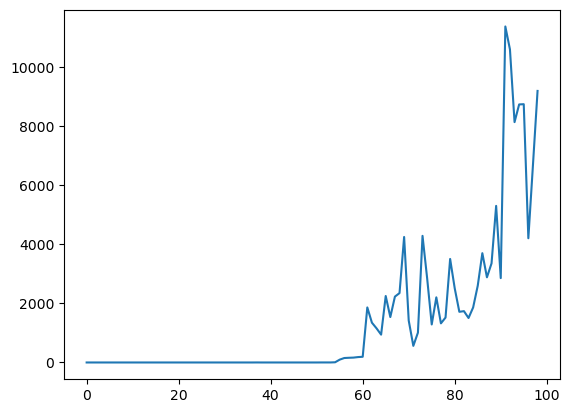

In [23]:
log_gomp_input['2021-2024_Total_EV_Sales'].plot()

<AxesSubplot:>

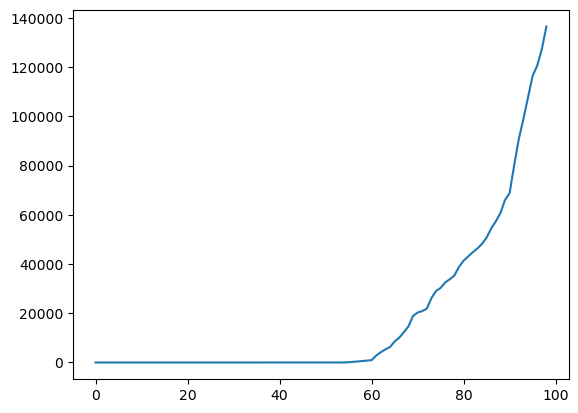

In [24]:
log_gomp_input['2021-2024_Total_EV_Sales'].cumsum().plot()

<AxesSubplot:>

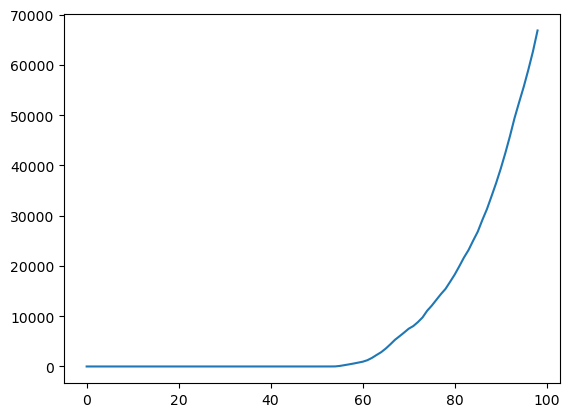

In [28]:
log_gomp_input['2021-2024'].cumsum().plot()

In [29]:
log_gomp_input.set_index('yr_month_dtype').loc['2023-06-01':'2023-08-01':, '2021-2024_Total_EV_Sales'].sum()

19524.0

C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_18412\1489039163.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  log_gomp_input.set_index('yr_month_dtype')


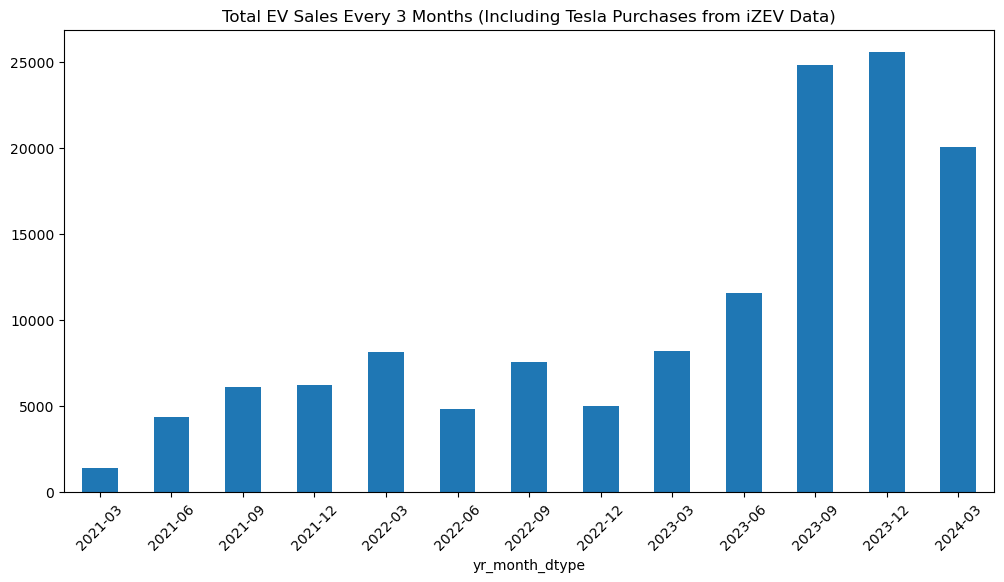

In [30]:
# Plot sum for every 3 months from January 2021 to March 2024
series = (
    log_gomp_input.set_index('yr_month_dtype')
    .loc['2021-03-01':'2024-03-01', '2021-2024_Total_EV_Sales']
    .resample('3M')
    .sum()
)

ax = series.plot(
    kind='bar',
    figsize=(12,6),
    title='Total EV Sales Every 3 Months (Including Tesla Purchases from iZEV Data)'
)

ax.set_xticklabels([d.strftime('%Y-%m') for d in series.index], rotation=45)

plt.show()

Comparing this graph with the BEV registrations from the [Statscan website](https://www150.statcan.gc.ca/n1/pub/71-607-x/71-607-x2021019-eng.htm) (shown below), we can see that from Q3 2023 to Q1 2024, there was a slow decline, whereas in our data, over the same period, the transactions first go up slightly between Q3 2023 and Q4 2023, before going down. And more importantly, there's a spike in sales from Q2 2024 through Q4 2024 that my model for sure cannot replicate.  

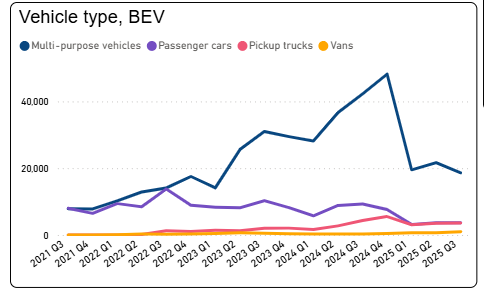

In [31]:
log_gomp_input['ZoneID'] = 'Canada_All'

In [32]:
log_gomp_input.to_csv('bass_input_all_canada_new_used_with_tesla.csv', index=True)